In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf
import tensorflow.keras as keras 
from warnings import filterwarnings as filt
import cv2 as cv 
import seaborn as sns 
import os
import gc

plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('dark_background')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
# !unzip /kaggle/input/facial-keypoints-detection/training.zip
# !unzip /kaggle/input/facial-keypoints-detection/test.zip

In [4]:
base_path = 'dataset'
base_train_path = os.path.join( base_path, 'training.csv' )
base_test_path  = os.path.join( base_path, 'test.csv' )

#### I am just going to localize for the most important features with null values < 60% 

* left and right eye center
* nose tip
* lips center

In [5]:
IMG_SIZE = 96
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 1)

In [6]:
def get_coordinates(df):
    location_coordinates = pd.DataFrame({}, columns = df.columns.map(lambda x : str(x)[:-2])[:-1].unique())
    coord_col = location_coordinates.columns
    for idx, row in df.iterrows():
        coords  = {col : (row[col + '_x'], row[col + '_y']) for col in coord_col}
        location_coordinates = location_coordinates.append(coords, ignore_index = True)
        
    location_coordinates.index = df.index
    
    
    return location_coordinates

to_xy_coord = lambda x : x.reshape(-1, 2)

In [147]:
def get_rows(num, col):
    if num % col:
        return num // col
    return ( num // col ) + 1

def plot_coords(coord, color = None):
    colors = ['aqua', 'red', 'yellow', 'green'] if not color else [color] * 4
    for ind, (x, y) in enumerate(coord):
        plt.scatter(x, y, c = colors[ind])

def show_imgs(imgs, coords, num = 15, col = 5, cmap = None):
    row = get_rows(num, col)
    plt.figure(figsize = (col * 4, row * 4))
    rand_idx = np.random.choice(np.arange(imgs.shape[0]), size = num)

    for iterr, idx in enumerate(rand_idx):
        img   = imgs[idx]
        coord = coords.iloc[idx]
        
        plt.subplot(row, col, iterr + 1)
        plt.imshow(img, cmap = cmap)
        plot_coords(coord.values)
        plt.axis(False)
    
    plt.show()
    
def plt_img(img, coord):
    plt.imshow(np.array(img, dtype = np.int32))
    plot_coords(coord)
    plt.axis('off');

In [8]:
import albumentations as A
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [180]:
def get_split_size(samples, frac = 0.02):
    vs = int(samples * frac)
    ts = int(samples) - vs
    print(f'Total size      :===> {samples}')
    print(f'Training size   :===> {ts}')
    print(f'Validation size :===> {vs}')
    
    return ts, vs

class GenerateIdx:
    def __init__(self, seed, samples, ts):
        np.random.seed(seed)
        idx_range = np.arange(samples)
        self.train_idx = np.random.choice(samples, ts, replace = False)
        self.valid_idx = np.array([i for i in idx_range if i not in self.train_idx])

class csvDataset(Dataset):
    def __init__(self, base_path, seed = 123, subset = 'train', transform = None, validation_split_frac = 0.02, channel_after = True):
        
        assert subset == 'train' or subset == 'validation' or subset == 'test', 'subset : ["train", "validation", "test"]'
        self.data = pd.read_csv(base_path)
        self.n_samples, self.n_features = self.data.shape
        self.transform = transform
        self.IMG_SIZE = 96
        self.subset = subset.lower()
        self.channel_after = channel_after 
        
        try:
            x_idx = [30]
            y_idx = [0, 1, 2, 3, 20, 21, 28, 29]
            non_nan_idx  = self.data.iloc[:, y_idx].dropna().index
            self.images = self.data.Image.values[non_nan_idx]
            self.labels = self.data.iloc[non_nan_idx, y_idx].values
            self.n_samples = self.images.shape[0]
        except:
            self.subset = 'test'

        print(f'Sampling {self.subset} data')
        if self.subset == 'train' or self.subset == 'validation':
            ts, vs = get_split_size(self.n_samples, validation_split_frac)
            self.cache = GenerateIdx(seed, self.n_samples, ts)
            self.train_images = self.images[self.cache.train_idx]
            self.train_labels = self.labels[self.cache.train_idx]
            self.valid_images = self.images[self.cache.valid_idx]
            self.valid_labels = self.labels[self.cache.valid_idx]
        else:
            self.images = self.data.Image
            self.labels = np.zeros((self.images.shape[0], 8))
            
        if self.subset == 'train':
            self.n_samples = self.train_images.shape[0]
        elif self.subset == 'validation':
            self.n_samples = self.valid_images.shape[0]
        else:
            self.n_samples = self.images.shape[0]
            
    def __getitem__(self, index):
        if self.subset == 'train':
            images = self.train_images
            labels = self.train_labels
        elif self.subset == 'validation':
            images = self.valid_images
            labels = self.valid_labels
        else:
            images = self.images
            labels = self.labels
        
        image = np.array(images[index].split()).reshape(self.IMG_SIZE, self.IMG_SIZE, 1).astype('uint8')
        samples = torch.from_numpy(image), torch.from_numpy(labels[index].flatten())

        if self.transform:
            params = {
                'image'     : cv.cvtColor(image, cv.COLOR_GRAY2RGB),
                'keypoints' : labels[index].reshape(-1, 2)
            }

            alb_samples = self.transform(**params)
            image = torch.from_numpy(alb_samples['image']) 
            label = torch.tensor(alb_samples['keypoints']).flatten()
            
            if self.channel_after:
                samples = image, label 
            else:
                samples = image.T, label 

        return samples

    def __len__(self):
        return self.n_samples
        
to_np_array = lambda x : np.array(list(map(int, x.split())))
to_int_list = lambda x : list(map(int, x.split()))


def show_augmented_images(data, num, col, cmap, channel_before = True):
    data = next(iter(data))
    num = min(num, data[1].shape[0])
    row = get_rows(num, col)
    plt.figure(figsize = (col * 4, row * 4))
    
    for i in range(num):
        plt.subplot(row, col, i + 1)
        
        if channel_before:
            image =  data[0][i].T
        else:
            image = data[0][i]
        plt.imshow(image)
        plot_coords(data[1][i].reshape(-1, 2))
        plt.axis(False)
    
    plt.plot()

In [174]:
def compute_mean_std(loader, channel_after = True, normalized = True):
    channel_sum, channel_squared_sum, num_batches = 0, 0, 0
    
    if channel_after: 
        dim = [0, 1, 2] # (M, H, W, C)
    else:
        dim = [0, 2, 3] # (M, C, H, W)
        
    for x, _ in loader:
        if not normalized:
            x = x / 255
        if x.dtype == torch.uint8:
            x = x.to(torch.float32)
        channel_sum         += torch.mean(x    , dim = dim)
        channel_squared_sum += torch.mean(x**2 , dim = dim)
        num_batches         += 1
        
    mean = channel_sum / num_batches
    std  = torch.sqrt(channel_squared_sum / num_batches - mean**2)
    return mean, std

In [175]:
mean, std = compute_mean_std(train_data, True, False) 
print(f'mean : {mean}')
print(f'std  : {std}')

mean : tensor([0.4897])
std  : tensor([0.2324])


In [50]:
# train_transform = A.Compose([
#     A.HorizontalFlip(p = 0.5),
#     A.OneOf([
#         A.Rotate(limit = 40,  p = 0.5, border_mode = cv.BORDER_CONSTANT),
#         A.Affine(scale = 1.0, shear = 15, mode = 0, p= 0.5)
#     ], p = 1),
#     A.VerticalFlip(p = 0.5),
#     A.RandomBrightnessContrast(p=0.4),
#     A.OneOf([
#         A.GaussianBlur(p = 0.4, blur_limit = (3, 5)),
#         A.GaussNoise(p = 0.2, var_limit = (10.0, 30.0))
#     ], p = 0.8),
#     A.ShiftScaleRotate(border_mode =  cv.BORDER_CONSTANT, p = 0.3),
#     A.Normalize(mean=[0.4897, 0.4897, 0.4897], std=[0.2330, 0.2330, 0.2330])
# ], keypoint_params= A.KeypointParams( format = 'xy', remove_invisible = False))

train_transform = A.Compose([
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Normalize(mean=[0.4897, 0.4897, 0.4897], std=[0.2324, 0.2324, 0.2324]),
], keypoint_params= A.KeypointParams( format = 'xy', remove_invisible = False))


dev_transform = A.Compose([
    A.Normalize(mean=[0.4897, 0.4897, 0.4897], std=[0.2324, 0.2324, 0.2324])
], keypoint_params = A.KeypointParams(format = 'xy', remove_invisible = False))

In [176]:
train_data = csvDataset(base_train_path, 0, 'train'     , train_transform, 0.02, channel_after = False)
valid_data = csvDataset(base_train_path, 0, 'validation', dev_transform, 0.02, channel_after = False)

Sampling train data
Total size      :===> 7000
Training size   :===> 6860
Validation size :===> 140
Sampling validation data
Total size      :===> 7000
Training size   :===> 6860
Validation size :===> 140


In [177]:
(train_data.cache.valid_idx == valid_data.cache.valid_idx).sum()

140

In [178]:
train_data = DataLoader(train_data, batch_size = 64, shuffle = True)
valid_data = DataLoader(valid_data, batch_size = 64, shuffle = False)

In [54]:
from warnings import filterwarnings as filt

filt('ignore')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

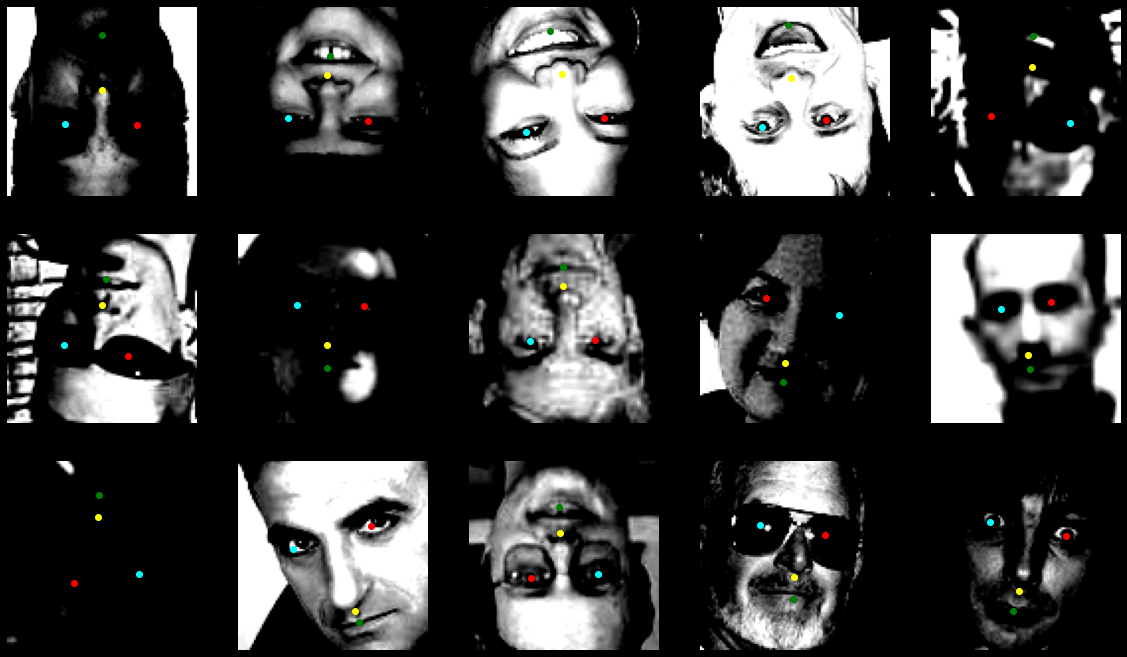

In [55]:
show_augmented_images(train_data, 15, 5, None, channel_before = True);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

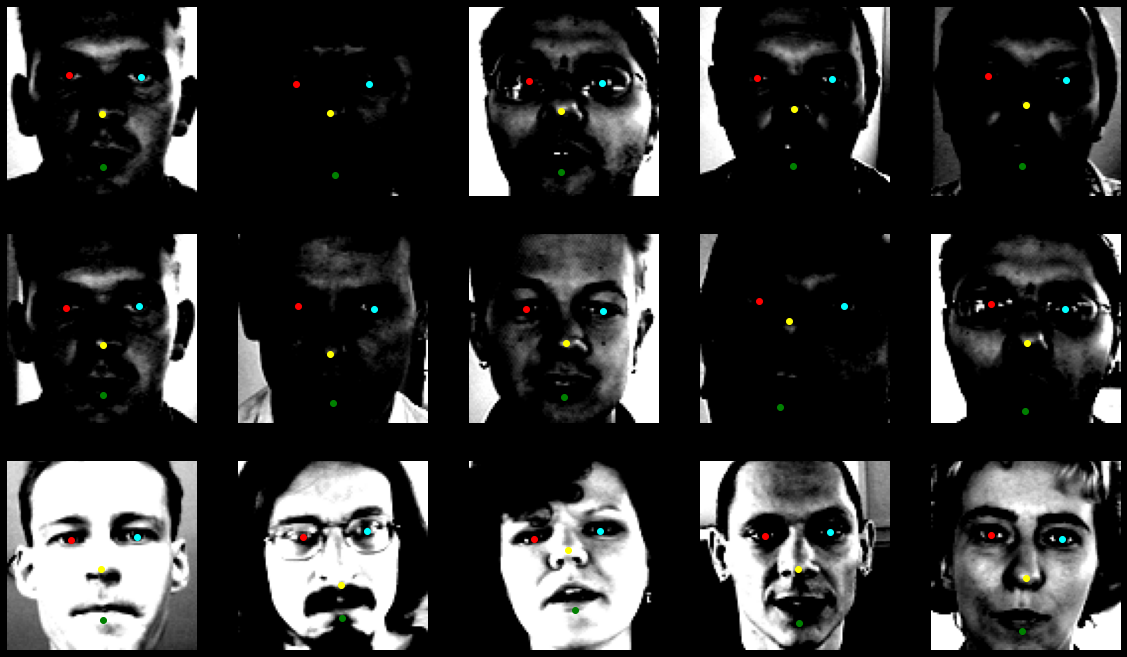

In [56]:
show_augmented_images(valid_data, 15, 5, None, channel_before = True);

In [57]:
import torch.nn as nn

class CNNBlock(nn.Module):
    def __init__(self, in_channel, out_channel, layer_activation = nn.ReLU(), **kwargs):
        super(CNNBlock, self).__init__()
        self.in_channel  = in_channel
        self.out_channel = out_channel
        self.cnn         = nn.Conv2d(self.in_channel, self.out_channel, **kwargs)
        self.batchNorm   = nn.BatchNorm2d(self.out_channel)
        self.activation  = layer_activation 
        
    def forward(self, x):
        return self.activation(self.batchNorm(self.cnn(x)))
    
class DenseBlock(nn.Module):
    def __init__(self, in_channel, out_channel, layer_activation = nn.ReLU(), dropout = 0.0):
        super(DenseBlock, self).__init__()
        self.in_channel  = int(in_channel)
        self.out_channel = int(out_channel)
        self.dense        = nn.Linear(self.in_channel, self.out_channel)
        self.dropout     = nn.Dropout2d(p = dropout)
        self.activation  = layer_activation 
        
    def forward(self, x):
        if self.activation:
            return self.activation(self.dropout(self.dense(x)))
        else:
            return self.dropout(self.dense(x))
        
def calculate_output_shape(W, K, pad, stride):
    return (((W - K) + (2 * pad)) / stride) + 1
    
class Model(nn.Module):
    def __init__(self, conv_architecture, layers, image_width, in_channel = 3, **kwargs):
        super(Model, self).__init__()
        self.arch       = conv_architecture
        self.layers     = layers
        self.in_channel = in_channel
        self.fcl_input  = -1 
        self.W          = image_width
        self.darknet    = self._create_conv_layers(self.arch)
        self.fcl        = self._create_fcl(self.layers)
        
    def forward(self, x):
        return self.fcl(self.darknet(x))
        
    def _create_conv_layers(self, architecture):
        layers = []
        for arch in architecture:
            if type(arch) == tuple or type(arch) == list:
                self.kernel_size, self.filters, self.stride, self.padding, activation = arch
                layers += [
                    CNNBlock(
                        self.in_channel, self.filters, activation, 
                        bias = False, 
                        kernel_size = self.kernel_size, 
                        stride = self.stride, 
                        padding = self.padding 
                    )]
                
                self.in_channel = self.filters
            else:
                self.kernel_size, self.stride, self.padding = 2, 2, 0
                layers += [nn.MaxPool2d(kernel_size = self.kernel_size, stride = self.stride)]
                   
            self.fcl_input = calculate_output_shape(self.W, self.kernel_size, self.padding, self.stride)
            self.W         = self.fcl_input
            
        self.fcl_input = self.W * self.W * self.filters
                
        return nn.Sequential(*layers)
    
    def _create_fcl(self, architecture):
        layers = [nn.Flatten()]
        for arch in architecture:
            ip, op, dropout, activation = arch
            ip = ip if ip != -1 else self.fcl_input
            layers += [
                DenseBlock(ip, op, activation, dropout)
            ]      
        return nn.Sequential(*layers)
    
    
def train_one_epoch(MODEL, x, y, optimizer, criterion):
    if not MODEL.training:
        MODEL.train()
        
    output = MODEL(x)
    loss   = criterion(output.to(torch.float64), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return MODEL, loss
    
def train_model(MODEL, train_data, epochs, optimizer, criterion, verbose = 1, print_at = 1, sanity_check = False):
    history = {
        'loss' : []
    }
    for epoch in range(epochs):
        losses = []
        for x, y in train_data:
            MODEL, loss = train_one_epoch(MODEL, x, y, optimizer, criterion)
            losses.append(loss.item())
            if sanity_check:
                break
        try:
            with torch.no_grad():
                loss = torch.mean(torch.tensor(losses))
                history['loss'].append(loss.item())
        except :
            pass
            
        if verbose > 0:
            if epoch % print_at == 0:
                print(f'Epoch :==> {epoch + 1} , Loss : {loss.item()}')
                
    return MODEL, history

def plot_history(history):
    loss = history['loss']
    plt.plot(loss)
    plt.show()

In [58]:
# config

conv_layers = [
    # kernel_size, filters, stride, padding, activation : torch.nn
    [5, 16, 1, 1, nn.ReLU()],
    [5, 32, 1, 1, nn.ReLU()],
    'M',
    [5, 32, 1, 1, nn.ReLU()],
    [5, 64, 1, 1, nn.ReLU()],
    'M'
]

dense_layers = [
    # ip, op, dropout, activation
    [-1 , 512, 0.0, nn.ReLU()],
    [512, 256, 0.0, nn.ReLU()],
    [256,   8, 0.0, None     ],
]

In [25]:
model = Model(conv_layers, dense_layers, IMG_SIZE, in_channel = 3)
model

Model(
  (darknet): Sequential(
    (0): CNNBlock(
      (cnn): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
      (batchNorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (1): CNNBlock(
      (cnn): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
      (batchNorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): CNNBlock(
      (cnn): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
      (batchNorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (4): CNNBlock(
      (cnn): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
      (batchNorm): BatchNorm2d(64, eps=1e-05, mom

In [ ]:
epochs        = 15
learning_rate = 1e-3
criterion     = nn.MSELoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)
model         = train_model(model, train_data, epochs, optimizer, criterion)

#### transfer learning 

In [59]:
from torchvision.models import resnet18, vgg16, resnet50

In [60]:
model = resnet50(pretrained = True)  
model.fc = nn.Linear(model.fc.in_features, 8)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [61]:
%%time
epochs        = 100
learning_rate = 1e-2
criterion     = nn.MSELoss(reduction = 'mean')
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)
model, his    = train_model(model, train_data, epochs, optimizer, criterion)

## testing

# sanity_check_train_data = csvDataset(base_train_path, 0, 'train', dev_transform, 0.02, channel_after = False)
# sanity_check_train_data = DataLoader(sanity_check_train_data, batch_size = 1, shuffle = True)
# model, his              = train_model(model, sanity_check_train_data, epochs, optimizer, criterion, sanity_check = True) 
# del model, epochs, sanity_check_train_data
# gc.collect()

Epoch :==> 1 , Loss : 188.55101013183594
Epoch :==> 2 , Loss : 103.10408782958984
Epoch :==> 3 , Loss : 101.29470825195312
Epoch :==> 4 , Loss : 100.46693420410156
Epoch :==> 5 , Loss : 99.15223693847656
Epoch :==> 6 , Loss : 99.90606689453125
Epoch :==> 7 , Loss : 96.83051300048828
Epoch :==> 8 , Loss : 94.66999053955078
Epoch :==> 9 , Loss : 93.39796447753906
Epoch :==> 10 , Loss : 93.02191925048828
Epoch :==> 11 , Loss : 92.14757537841797
Epoch :==> 12 , Loss : 90.43018341064453
Epoch :==> 13 , Loss : 90.0271987915039
Epoch :==> 14 , Loss : 89.16778564453125
Epoch :==> 15 , Loss : 87.18682098388672
Epoch :==> 16 , Loss : 83.96138000488281
Epoch :==> 17 , Loss : 84.29005432128906
Epoch :==> 18 , Loss : 83.42524719238281
Epoch :==> 19 , Loss : 82.39604949951172
Epoch :==> 20 , Loss : 80.92147827148438
Epoch :==> 21 , Loss : 80.34957122802734
Epoch :==> 22 , Loss : 79.17628479003906
Epoch :==> 23 , Loss : 78.51388549804688
Epoch :==> 24 , Loss : 79.76250457763672
Epoch :==> 25 , Loss :

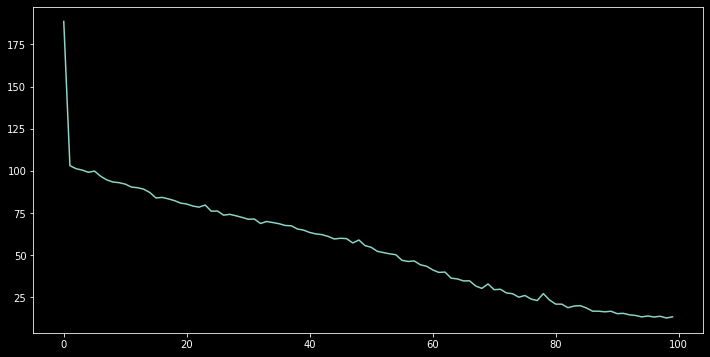

In [65]:
plot_history(his)

In [140]:
from sklearn.metrics import r2_score as rscore

def predict(MODEL, loader, criterion, sanity_check = False):
    preds  = []
    losses = []
    with torch.no_grad():
        for ind, (x, y) in enumerate(loader):
            MODEL.eval()
            if not MODEL.training:
                print(f'Evaluating the batch ({ind + 1}) from the validation/testing data ...')
                pred = MODEL(x)
                loss = criterion(pred.to(torch.float64), y)
                
                losses.append(loss.item())
                preds.append(pred)
            if sanity_check:
                break
        
        print()
        print(f'Validation/testing loss : {torch.mean(torch.tensor(losses)).item()}')
    MODEL.train()
    return preds

def get_scores(loader, preds, return_acc = True):
    scores = []
    with torch.no_grad():
        for ind, (_, y) in enumerate(loader):
            pred = preds[ind]
            left_eye_x  = rscore(y[:, 0], pred[:, 0])    
            left_eye_y  = rscore(y[:, 1], pred[:, 1])
            right_eye_x = rscore(y[:, 2], pred[:, 2])
            right_eye_y = rscore(y[:, 3], pred[:, 3])
            nose_tip_x  = rscore(y[:, 4], pred[:, 4])
            nose_tip_y  = rscore(y[:, 5], pred[:, 5])
            mouth_x     = rscore(y[:, 6], pred[:, 6])
            mouth_y     = rscore(y[:, 7], pred[:, 7])
            
            scores += [[left_eye_x, left_eye_y, right_eye_x, right_eye_y, nose_tip_x, nose_tip_y, mouth_x, mouth_y]]
        
        scores = np.mean(np.array(scores), axis = 0)
        print('Mean scores of each feature'.center(60, '='))
        print()
        print(f'Left eye  X  : {scores[0]:.2f}')
        print(f'Left eye  Y  : {scores[1]:.2f}')
        print(f'Right eye X  : {scores[2]:.2f}')
        print(f'Right eye Y  : {scores[3]:.2f}')
        print(f'Nose tip  X  : {scores[4]:.2f}')
        print(f'Nose tip  Y  : {scores[5]:.2f}')
        print(f'Mouth     X  : {scores[6]:.2f}')
        print(f'Mouth     Y  : {scores[7]:.2f}')
    if return_acc:
        return scores

In [130]:
preds = predict(model, valid_data, criterion)

Evaluating the batch (1) from the validation/testing data ...
Evaluating the batch (2) from the validation/testing data ...
Evaluating the batch (3) from the validation/testing data ...

Validation/testing loss : 97.8736801147461


In [141]:
get_scores(valid_data, preds, False)

================Mean scores of each feature=================

Left eye  X  : -39.53
Left eye  Y  : 0.20
Right eye X  : -66.74
Right eye Y  : -0.68
Nose tip  X  : 0.16
Nose tip  Y  : 0.06
Mouth     X  : 0.65
Mouth     Y  : 0.27


In [157]:
def show_test_pred(loader, preds, num = 15, col = 5, has_output = True, channel_after = False):
    batch_size = len(loader) 
    bnum = np.random.randint(0, batch_size)
    
    images, labels = list(loader)[bnum]
    preds = preds[bnum]
    
    num = min(num, labels.shape[0])
    row = get_rows(num, col)
    
    plt.figure(figsize = (col * 4, row * 4))
    print('Red dots  : predicted co-ordinates')
    if has_output:
        print('Blue dots : true co-ordinates')
        
    for i in range(num):
        plt.subplot(row, col, i + 1)
        
        img = images[i] if channel_after else images[i].T
        plt.imshow(img)
        
        plot_coords(preds[i].reshape(-1, 2), 'red')
        if has_output:
            plot_coords(labels[i].reshape(-1, 2), 'blue')
            
    plt.show()
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Red dots  : predicted co-ordinates
Blue dots : true co-ordinates


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

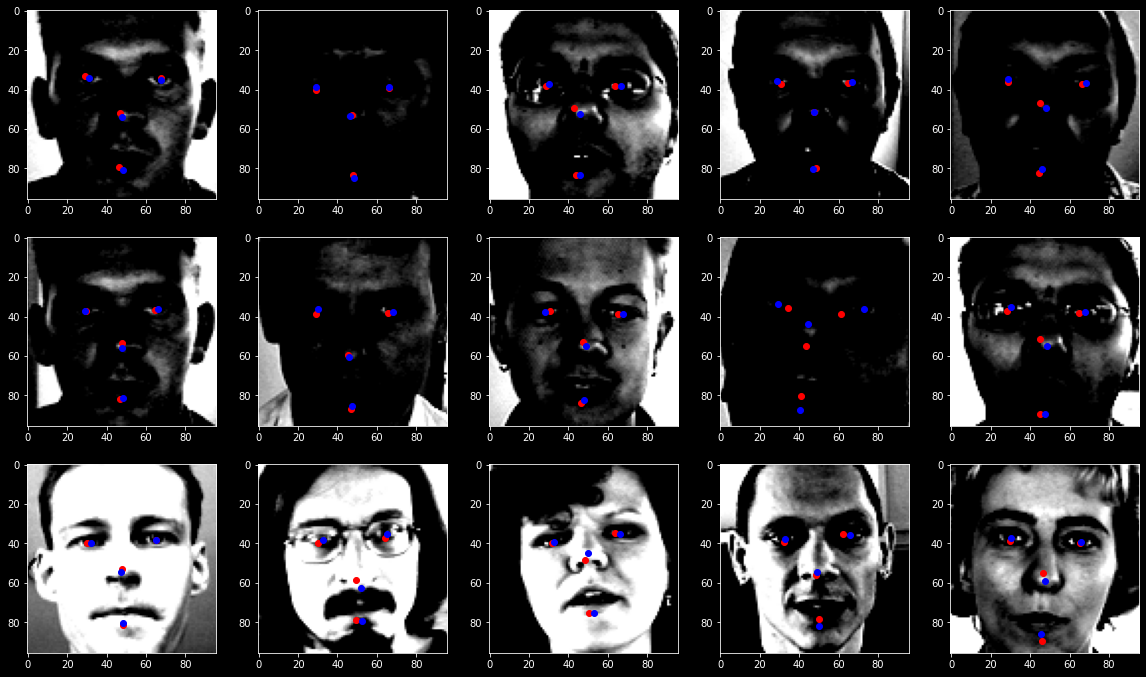

In [158]:
show_test_pred(valid_data, preds)

In [181]:
test_data = csvDataset(base_test_path, 0, 'test', dev_transform, channel_after = False)
test_data = DataLoader(test_data, batch_size = 64, shuffle = False)

Sampling test data


In [187]:
preds = predict(model, test_data, criterion)

Evaluating the batch (1) from the validation/testing data ...
Evaluating the batch (2) from the validation/testing data ...
Evaluating the batch (3) from the validation/testing data ...
Evaluating the batch (4) from the validation/testing data ...
Evaluating the batch (5) from the validation/testing data ...
Evaluating the batch (6) from the validation/testing data ...
Evaluating the batch (7) from the validation/testing data ...
Evaluating the batch (8) from the validation/testing data ...
Evaluating the batch (9) from the validation/testing data ...
Evaluating the batch (10) from the validation/testing data ...
Evaluating the batch (11) from the validation/testing data ...
Evaluating the batch (12) from the validation/testing data ...
Evaluating the batch (13) from the validation/testing data ...
Evaluating the batch (14) from the validation/testing data ...
Evaluating the batch (15) from the validation/testing data ...
Evaluating the batch (16) from the validation/testing data ...
E

dont mind the loss for the above test data since there's no labels for them 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Red dots  : predicted co-ordinates


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

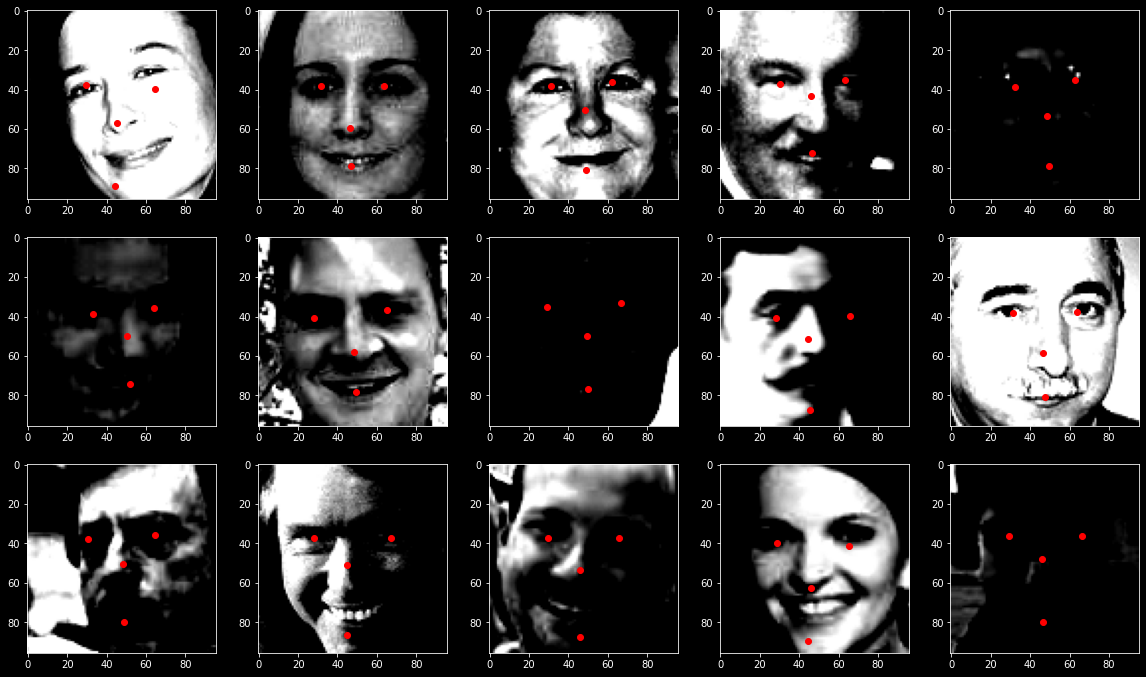

In [188]:
show_test_pred(valid_data, preds, has_output=False)

In [68]:
def save_checkpoint(checkpoint, filename = 'model_checkpoint.pth.tar'):
    checkpoint = {
        'model_state' : checkpoint[0].state_dict(),
        'optim_state' : checkpoint[1].state_dict()
    }
    torch.save(checkpoint, filename)
    print('saved the model ...')
    
def load_checkpoiint(model, optim, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state'])
    optim.load_state_dict(checkpoint['optim_state'])
    
    return model, optim
     
# checkpoint = {
#     'model_state'     : model.state_dict(),
#     'optimizer_state' : optimizer.state_dict()
# }

checkpoint = [model, optimizer]
save_checkpoint(checkpoint)

saved the model ...
